In [ ]:
import pandas as pd
import numpy as np
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/Datasets/resource_allocation_large_tasks.xlsx'
df = pd.read_excel(data_path)
df.head(5)

,Task ID,Task Name,Resource Requirement (Budget in $),Value Contribution ($)
0,1,Task 1,2456,14045
1,2,Task 2,1193,2068
2,3,Task 3,4419,16288
3,4,Task 4,751,13975
4,5,Task 5,2671,1487


#PSO
number of particles=50
the max contribution=898418

when number of particles increased to 70 and iteration to 150 inertia to .8 the max contribution was 857000.

when penalty was imposed on objective function to discourage the invalid soltuion contribution was 890000

In [ ]:
import numpy as np
import pandas as pd

#total_resource_requirement = df['Resource Requirement (Budget in $)'].sum()
total_budget_limit = 150000

#objective Function
def objective_function(selected_tasks):
    total_budget = selected_tasks['Resource Requirement (Budget in $)'].sum()
    total_value = selected_tasks['Value Contribution ($)'].sum()

    # Return a penalty if the budget exceeds the limit
    if total_budget > total_budget_limit:
        return -9999 - (total_budget - total_budget_limit)  # Gradually increasing penalty

    return total_value


n_particles = 50
n_iterations = 100
inertia_weight = 0.9 #balance between exploration and exploitation, high-->new exploration
c1 = 1.5  #how much the particle is influenced by pBest and gBest
c2 = 1.5

#Task details
n_tasks = len(df)
execution_times = {}
start_time = time.perf_counter()

# Function to initialize particles with feasible selections
def initialize_particles(num_particles, num_tasks, budget_limit):
    particles = np.zeros((num_particles, num_tasks), dtype=int)
    for i in range(num_particles):
        total_budget = 0
        while total_budget <= budget_limit:
            task_to_add = np.random.randint(num_tasks)
            particles[i][task_to_add] = 1
            total_budget = df.iloc[np.where(particles[i] == 1)]['Resource Requirement (Budget in $)'].sum()
    return particles

# PSO initialization: position and velocity
particles = initialize_particles(n_particles, n_tasks, total_budget_limit)
velocities = np.random.rand(n_particles, n_tasks) * 0.1 #matrox 0..1 to scale velcoity 0.1,  enocurage gradual changes to task selection

# Initialize personal
personal_best_positions = particles.copy()
personal_best_scores = np.array([objective_function(df.iloc[np.where(p == 1)]) for p in particles])#array of best score for all particles

# Initialize global best
global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
global_best_score = max(personal_best_scores)


for iteration in range(n_iterations):
    for i in range(n_particles):
        # Calculate fitness of the particle
        selected_tasks = df.iloc[np.where(particles[i] == 1)]
        fitness = objective_function(selected_tasks)

        # Update personal best
        if fitness > personal_best_scores[i]:
            personal_best_scores[i] = fitness
            personal_best_positions[i] = particles[i].copy()

        # Update global best
        if fitness > global_best_score:
            global_best_score = fitness
            global_best_position = particles[i].copy()

        # Update particle velocity and position
        velocities[i] = (inertia_weight * velocities[i] +
                         c1 * np.random.rand() * (personal_best_positions[i] - particles[i]) +
                         c2 * np.random.rand() * (global_best_position - particles[i]))

        velocities[i] = np.clip(velocities[i], -1, 1)
        prob = 1 / (1 + np.exp(-velocities[i]))
        new_positions = np.where(np.random.rand(n_tasks) < prob, 1, 0)

        # New position check the budget condition
        if np.sum(new_positions) > 0:  # If any tasks selected
            total_budget = df.iloc[np.where(new_positions == 1)]['Resource Requirement (Budget in $)'].sum()
            # If budget exceeded, keep selecting tasks until within budget
            while total_budget > total_budget_limit:
                task_to_remove = np.random.choice(np.where(new_positions == 1)[0])
                new_positions[task_to_remove] = 0
                total_budget = df.iloc[np.where(new_positions == 1)]['Resource Requirement (Budget in $)'].sum()

        particles[i] = new_positions
pso_time = time.perf_counter() - start_time
execution_times['PSO'] = pso_time
# Final global best result
optimal_tasks_pso = df.iloc[np.where(global_best_position == 1)]
optimal_value_pso = global_best_score

print("Optimal Tasks from PSO:")
print(optimal_tasks_pso[['Task ID', 'Task Name', 'Resource Requirement (Budget in $)', 'Value Contribution ($)']])
print("Total Budget is :",total_budget)
print(f"Total Value Achieved by PSO: {optimal_value_pso}")
print(f"Execution Time (PSO): {pso_time:.2f} seconds\n")



Optimal Tasks from PSO:
     Task ID Task Name  Resource Requirement (Budget in $)  \
51        52   Task 52                                1233   
54        55   Task 55                                2383   
68        69   Task 69                                 317   
94        95   Task 95                                 454   
100      101  Task 101                                 624   
..       ...       ...                                 ...   
936      937  Task 937                                1737   
946      947  Task 947                                 529   
947      948  Task 948                                1148   
982      983  Task 983                                2579   
984      985  Task 985                                3558   

     Value Contribution ($)  
51                    18210  
54                     9524  
68                     3964  
94                     1805  
100                   10906  
..                      ...  
936                  

#GA

In [ ]:
import numpy as np
import pandas as pd


total_budget_limit = 150000
def objective_function(selected_tasks):
    total_budget = selected_tasks['Resource Requirement (Budget in $)'].sum()
    total_value = selected_tasks['Value Contribution ($)'].sum()

    #penalty if the budget exceeds the limit
    if total_budget > total_budget_limit:
        penalty = (total_budget - total_budget_limit) * 0.1
        return total_value - penalty

    # If within the budget, return the total value
    return total_value


population_size = 400
n_generations = 300
mutation_rate = 0.05
n_tasks = len(df)

# Initialize the population: random 0 or 1 for task selection
population = np.random.randint(2, size=(population_size, n_tasks))

start_time = time.perf_counter()

# Function to perform crossover between two parents
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, n_tasks-1)  # Select crossover point randomly
    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return child1, child2

# Function to perform mutation on a child
def mutate(child):
    for i in range(n_tasks):
        if np.random.rand() < mutation_rate:
            child[i] = 1 - child[i]  # Flip the bit (binary mutation)
    return child


for generation in range(n_generations):
    # Evaluate fitness for the current population
    fitness_scores = np.array([objective_function(df.iloc[np.where(individual == 1)]) for individual in population])

    # Select individuals for the next generation based on fitness
    probabilities = fitness_scores / np.sum(fitness_scores)
    selected_indices = np.random.choice(population_size, size=population_size, p=probabilities)
    selected_population = population[selected_indices]

    # Create new population using crossover and mutation
    new_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected_population[i], selected_population[i+1]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.append(child1)
        new_population.append(child2)

    # Update population for the next generation
    population = np.array(new_population)
ga_time = time.perf_counter() - start_time
execution_times['GA'] = ga_time
# After all generations, find the best individual
best_individual = population[np.argmax([objective_function(df.iloc[np.where(individual == 1)]) for individual in population])]
optimal_tasks_ga = df.iloc[np.where(best_individual == 1)]
optimal_value_ga = objective_function(optimal_tasks_ga)

print("Optimal Tasks:")
print(optimal_tasks_ga[['Task ID', 'Task Name', 'Resource Requirement (Budget in $)', 'Value Contribution ($)']])
print("Total Budget is :",total_budget)
print(f"Optimal Value Achieved by GA: {optimal_value_ga}")
print(f"Execution Time (GA): {ga_time:.2f} seconds\n")


Optimal Tasks:
     Task ID  Task Name  Resource Requirement (Budget in $)  \
0          1     Task 1                                2456   
2          3     Task 3                                4419   
3          4     Task 4                                 751   
5          6     Task 6                                2351   
6          7     Task 7                                3296   
..       ...        ...                                 ...   
990      991   Task 991                                4506   
991      992   Task 992                                 583   
994      995   Task 995                                1032   
995      996   Task 996                                3145   
999     1000  Task 1000                                1676   

     Value Contribution ($)  
0                     14045  
2                     16288  
3                     13975  
5                     11602  
6                     16049  
..                      ...  
990               

#DE

In [ ]:
import time
start_time = time.perf_counter()

population_size = 50
n_generations = 100
F = 0.8
CR = 0.7

n_tasks = len(df)
population = np.random.randint(2, size=(population_size, n_tasks))

start_time = time.perf_counter()

for generation in range(n_generations):
    for i in range(population_size):
        # Mutation: Select 3 random individuals from the population, ensuring they are different from each other and the current individual
        indices = np.random.choice([x for x in range(population_size) if x != i], 3, replace=False)
        a, b, c = population[indices]

        # Create a mutant vector
        mutant_vector = np.clip(a + F * (b - c), 0, 1)

        # Crossover: Create trial vector by mixing mutant with the target individual
        trial_vector = np.copy(population[i])
        for j in range(n_tasks):
            if np.random.rand() < CR:
                trial_vector[j] = mutant_vector[j]

        # Convert trial_vector to binary
        trial_vector = np.where(trial_vector >= 0.5, 1, 0)

        # Selection: Compare fitness of trial_vector and target individual
        fitness_trial = objective_function(df.iloc[np.where(trial_vector == 1)])
        fitness_target = objective_function(df.iloc[np.where(population[i] == 1)])

        if fitness_trial > fitness_target:
            population[i] = trial_vector

de_time = time.perf_counter() - start_time
execution_times['DE'] = de_time
#Find the best individual
best_individual_de = population[np.argmax([objective_function(df.iloc[np.where(individual == 1)]) for individual in population])]
optimal_tasks_de = df.iloc[np.where(best_individual_de == 1)]
optimal_value_de = objective_function(optimal_tasks_de)

print("Optimal Tasks (Differential Evolution):")
print(optimal_tasks_de)
print("Total Budget is :",total_budget)
print(f"Optimal Value Achieved (DE): {optimal_value_de}")
print(f"Execution Time (DE): {de_time:.2f} seconds\n")


Optimal Tasks (Differential Evolution):
     Task ID Task Name  Resource Requirement (Budget in $)  \
1          2    Task 2                                1193   
3          4    Task 4                                 751   
4          5    Task 5                                2671   
5          6    Task 6                                2351   
8          9    Task 9                                3805   
..       ...       ...                                 ...   
986      987  Task 987                                2849   
989      990  Task 990                                2360   
990      991  Task 991                                4506   
993      994  Task 994                                4500   
995      996  Task 996                                3145   

     Value Contribution ($)  
1                      2068  
3                     13975  
4                      1487  
5                     11602  
8                      9526  
..                      ...  
986  

#Excution time of Algo

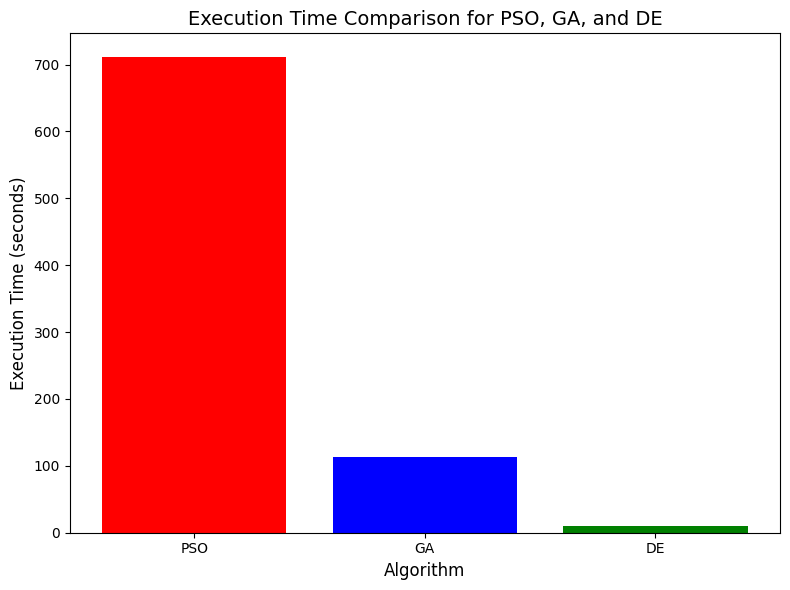

In [ ]:
import matplotlib.pyplot as plt


def visualize_execution_times(execution_times):
    algorithms = list(execution_times.keys())
    times = list(execution_times.values())


    plt.figure(figsize=(8, 6))
    plt.bar(algorithms, times, color=['red', 'blue', 'green'])


    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('Execution Time Comparison for PSO, GA, and DE', fontsize=14)

    plt.tight_layout()
    plt.show()

visualize_execution_times(execution_times)


#optimal tasks numbers and their values

In [ ]:

def display_optimal_allocation(optimal_tasks, optimal_value, algorithm_name):
    print(f"{algorithm_name} Optimal Tasks:")
    print(optimal_tasks[['Task ID', 'Task Name', 'Resource Requirement (Budget in $)', 'Value Contribution ($)']])
    print(f"Total Value Achieved by {algorithm_name}: {optimal_value}\n")

display_optimal_allocation(optimal_tasks_pso, optimal_value_pso, "PSO")
display_optimal_allocation(optimal_tasks_ga, optimal_value_ga, "GA")
display_optimal_allocation(optimal_tasks_de, optimal_value_de, "DE")


PSO Optimal Tasks:
     Task ID Task Name  Resource Requirement (Budget in $)  \
51        52   Task 52                                1233   
54        55   Task 55                                2383   
68        69   Task 69                                 317   
94        95   Task 95                                 454   
100      101  Task 101                                 624   
..       ...       ...                                 ...   
936      937  Task 937                                1737   
946      947  Task 947                                 529   
947      948  Task 948                                1148   
982      983  Task 983                                2579   
984      985  Task 985                                3558   

     Value Contribution ($)  
51                    18210  
54                     9524  
68                     3964  
94                     1805  
100                   10906  
..                      ...  
936                    270

#Total Contribution by Each algo

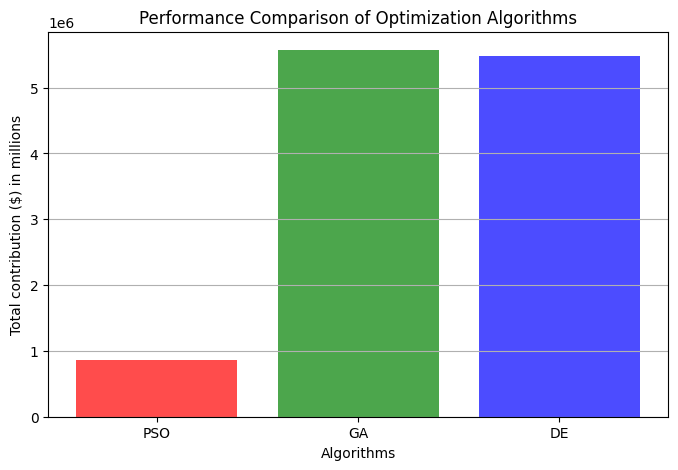

In [ ]:
import matplotlib.pyplot as plt


def visualize_algorithm_performance(pso_value, ga_value, de_value):
    algorithms = ['PSO', 'GA', 'DE']
    values = [pso_value, ga_value, de_value]

    plt.figure(figsize=(8, 5))
    plt.bar(algorithms, values, color=['red', 'green', 'blue'], alpha=0.7)
    plt.title('Performance Comparison of Optimization Algorithms')
    plt.xlabel('Algorithms')
    plt.ylabel('Total contribution ($) in millions')
    plt.grid(axis='y')
    plt.show()


visualize_algorithm_performance(optimal_value_pso,optimal_value_ga, optimal_value_de)
